In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

u_star = np.array([
    [0, 0.5, 0, 0.5, 0],
    [0.5, 0, 0.5, 0, 0.5],
    [0, 0.5, 0, 0.5, 0],
    [0.5, 0, 0.5, 0, 0],
    [0, 0.5, 0, 0, 0]
])

y_init = np.array([1, -1, -1, 1, 1])
p = len(y_init)

def ising_gibbs_sampler(u, y_init, n_samples=1000, burn_in=5000):
    """
    Gibbs sampler for the Ising model
    
    Parameters:
    u: interaction matrix (p x p)
    y_init: initial state (p,)
    n_samples: number of samples to generate after burn-in
    burn_in: number of burn-in samples
    
    Returns:
    samples: array of shape (n_samples, p)
    """
    p = len(y_init)
    total_samples = n_samples + burn_in
    samples = np.zeros((total_samples, p))
    samples[0] = y_init.copy()
    
    for n in range(1, total_samples):
        # Start from previous sample
        y_current = samples[n-1].copy()
        
        # Update each variable in sequence
        for r in range(p):
            # Compute A = sum_{t != r} u_{r,t} y_t
            A = 0
            for t in range(p):
                if t != r:
                    A += u[r, t] * y_current[t]
            
            # Compute probability P(y_r = 1 | y_{V\r})
            p_plus = np.exp(2 * A) / (np.exp(2 * A) + 1)
            
            # Sample y_r
            if np.random.rand() < p_plus:
                y_current[r] = 1
            else:
                y_current[r] = -1
        
        samples[n] = y_current.copy()
    
    # Return samples after burn-in
    return samples[burn_in:]

In [2]:
samples = ising_gibbs_sampler(u_star, y_init)

sample_mean = np.mean(samples, axis=0)
sample_var = np.var(samples, axis=0)

print("\nSample Statistics:")
print(f"{'Variable':<10} {'Mean':<10} {'Variance':<10}")
for i in range(p):
    print(f"{i+1:<10} {sample_mean[i]:<10.3f} {sample_var[i]:<10.3f}")


Sample Statistics:
Variable   Mean       Variance  
1          -0.024     0.999     
2          0.016      1.000     
3          0.024      0.999     
4          0.026      0.999     
5          0.014      1.000     



Correlation Matrix:
[[1.         0.51259725 0.38479764 0.50293884 0.24643113]
 [0.51259725 1.         0.54784391 0.37375818 0.46988219]
 [0.38479764 0.54784391 1.         0.48968254 0.30978358]
 [0.50293884 0.37375818 0.48968254 1.         0.21172832]
 [0.24643113 0.46988219 0.30978358 0.21172832 1.        ]]


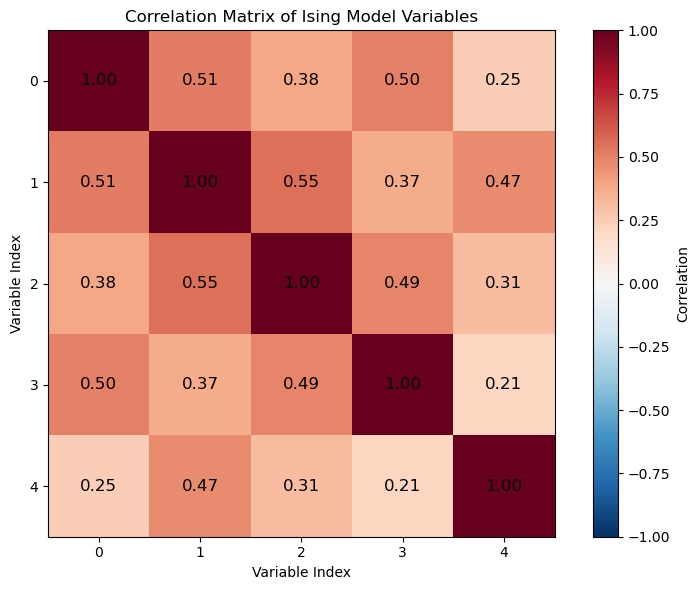

In [3]:
# corr
correlation_matrix = np.corrcoef(samples.T)

print("\nCorrelation Matrix:")
print(correlation_matrix)

# Plot correlation matrix
plt.figure(figsize=(8, 6))
im = plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation')
plt.title('Correlation Matrix of Ising Model Variables')
plt.xlabel('Variable Index')
plt.ylabel('Variable Index')

# Add correlation values as text
for i in range(p):
    for j in range(p):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', 
                ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

In [4]:
from scipy.stats import laplace
import math

np.random.seed(100)

def metropolis_hastings(log_target, initial_state, proposal_std=0.1, n_samples=1000, burn_in=10000):

    n_params = len(initial_state)
    total_samples = n_samples + burn_in
    samples = np.zeros((total_samples, n_params))
    samples[0] = initial_state.copy()
    
    current_state = initial_state.copy()
    current_log_target = log_target(current_state)
    
    for n in range(1, total_samples):
        # Propose new state (Gaussian random walk)
        proposed_state = current_state + np.random.normal(0, proposal_std, n_params)
        
        # Compute log-target for proposed state
        proposed_log_target = log_target(proposed_state)
        
        # acceptance probability
        log_alpha = proposed_log_target - current_log_target
        alpha = min(1, np.exp(log_alpha))
        
        # accept/reject
        if np.random.rand() < alpha:
            current_state = proposed_state
            current_log_target = proposed_log_target
        
        samples[n] = current_state.copy()
    
    return samples[burn_in:]

def vectorize_u(u):
    """Convert symmetric matrix to vector of free parameters"""
    p = u.shape[0]
    u_vec = []
    for i in range(p):
        for j in range(i+1, p):
            u_vec.append(u[i, j])
    return np.array(u_vec)

def unvectorize_u(u_vec, p=5):
    """Convert vector back to symmetric matrix"""
    u_mat = np.zeros((p, p))
    idx = 0
    for i in range(p):
        for j in range(i+1, p):
            u_mat[i, j] = u_vec[idx]
            u_mat[j, i] = u_vec[idx]
            idx += 1
    return u_mat

def partition(u_mat):
    """Compute partition function Z(u) by brute force"""
    p = u_mat.shape[0]
    states = []
    
    # Generate all 2^p possible states
    for i in range(2**p):
        state = []
        for j in range(p):
            state.append(1 if (i >> j) & 1 else -1)
        states.append(state)
    
    states = np.array(states)
    
    # Compute Z(u) = sum_y exp(sum_{i<j} u_ij y_i y_j)
    Z = 0
    for state in states:
        energy = 0
        for i in range(p):
            for j in range(i+1, p):
                energy += u_mat[i, j] * state[i] * state[j]
        Z += np.exp(energy)
    
    return Z

def log_posterior(data, lamb=0.2):
    """Create log-posterior function for given data"""
    def log_posterior(u_vec):
        # Convert to matrix form
        u_mat = unvectorize_u(u_vec)
        
        # Compute log-likelihood
        log_lik = 0
        for sample in data:
            energy = 0
            for i in range(5):
                for j in range(i+1, 5):
                    energy += u_mat[i, j] * sample[i] * sample[j]
            log_lik += energy
        
        # Subtract log partition function
        Z = partition(u_mat)
        log_lik -= len(data) * np.log(Z)
        
        # Compute log-prior (Laplace prior)
        log_prior = np.sum(laplace.logpdf(u_vec, scale=1/lamb))
        
        return log_lik + log_prior
    
    return log_posterior

In [5]:
# log-posterior function
log_posterior_fn = log_posterior(samples)

# Initial state
initial_u_vec = np.zeros(int(p*(p-1)/2)) + 0.1  # free parameters

# MCMC
samples_u = metropolis_hastings(log_target=log_posterior_fn, initial_state=initial_u_vec)

In [6]:
# Analysis

true_u_vec = vectorize_u(u_star)
posterior_means = np.mean(samples_u, axis=0)
posterior_vars = np.var(samples_u, axis=0)

print("\nCOMPARISON: TRUE vs ESTIMATED")
param_labels = []
p = 5
for i in range(p):
    for j in range(i+1, p):
        param_labels.append(f"u_{i+1}{j+1}")

print(f"{'Parameter':<10} {'True':<10} {'Sample_Mean':<12} {'Error':<10} {'Sample_Variance':<10}")
for idx, label in enumerate(param_labels):
    true_val = true_u_vec[idx]
    est_mean = posterior_means[idx]
    est_var = posterior_vars[idx]
    error = abs(true_val - est_mean)
    print(f"{label:<10} {true_val:<10.3f} {est_mean:<11.3f}  {error:<10.3f} {est_var:<10.6f}")


COMPARISON: TRUE vs ESTIMATED
Parameter  True       Sample_Mean  Error      Sample_Variance
u_12       0.500      0.482        0.018      0.000297  
u_13       0.000      -0.007       0.007      0.000676  
u_14       0.500      0.500        0.000      0.002574  
u_15       0.000      -0.008       0.008      0.000360  
u_23       0.500      0.456        0.044      0.001551  
u_24       0.000      -0.037       0.037      0.000968  
u_25       0.500      0.442        0.058      0.000693  
u_34       0.500      0.497        0.003      0.000483  
u_35       0.000      0.163        0.163      0.000981  
u_45       0.000      -0.044       0.044      0.000747  


In [7]:
estimated_u_mat = unvectorize_u(posterior_means)

print("\nTRUE u*:")
print(np.round(u_star, 3))
print("\nESTIMATED u:")
print(np.round(estimated_u_mat, 3))


TRUE u*:
[[0.  0.5 0.  0.5 0. ]
 [0.5 0.  0.5 0.  0.5]
 [0.  0.5 0.  0.5 0. ]
 [0.5 0.  0.5 0.  0. ]
 [0.  0.5 0.  0.  0. ]]

ESTIMATED u:
[[ 0.     0.482 -0.007  0.5   -0.008]
 [ 0.482  0.     0.456 -0.037  0.442]
 [-0.007  0.456  0.     0.497  0.163]
 [ 0.5   -0.037  0.497  0.    -0.044]
 [-0.008  0.442  0.163 -0.044  0.   ]]
